In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# SETTING PARAMETERS
cat_client = "IRIS" # source catalog for eqs (str)
wf_client = "IRIS" # source catalog for wf, likely the same as cat_client (str)
net = "XP" # network.code (str)
sta = "*"
#sta = "ACSO,M48A,N50A,O50A,O51A,P52A,P54A,Q55A,R56A,R57A,R58A,S58A,S59A,N49A,O52A,P53A,R58B,ALMA,AZZI,BARB,BDEG,CABN,CAKE,CDRF,DENI,FOXP,INTX,JSPR,KENT,LADY,LBDL,MOLE,MUSK,NAZF,PAUL,PETO,PVGR,RTSN,SUSI,TRTF,WINE,WIRE,WLFT,WTMN,YLDA" # station.code (str)
loc = "*" # leaves this value open (str)  -- TA network stations have no location code
cha = "BH?" # gets the broadband channels
startdate = "2015-08-01"
enddate = "2019-08-01"
minmag = 5.5 # minimum magnitude (int/float)
mindis = 30 # minimum distance in degrees (radius) (int/float)
maxdis = 90 # maximum distance in degrees (int/float)
max_event_depth = 750
phases = ['P'] # list of phases to be picked, first arriving phase will get picked
onedmodel = "ak135" # "ak135" or "PREM" or other
before = 30 # seconds before p wave arrival (int)
after = 120 # seconds after p wave arrival (int)
save_dir = '/Users/12036/OneDrive/Desktop/Yale/GRTdata/SEISConn/'

In [2]:
import obspy
from obspy import read
from obspy import UTCDateTime, read, Stream, Trace, read_inventory,  Catalog
from obspy.clients.fdsn import Client
from obspy.io.sac.sactrace import SACTrace
from obspy.core.trace import Stats
import numpy as np
import obspy.geodetics.base
from obspy.geodetics.base import gps2dist_azimuth
import obspy.taup
from obspy.taup import TauPyModel
import obspy.taup.taup_geo 
import obspy.signal
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import os
import shutil
import sys
import datetime
from operator import itemgetter
import glob
from scipy.signal import windows, freqz
import csv
from csv import reader
from mpl_toolkits.basemap import Basemap
from statistics import mean
import math

In [3]:
# Quality control function, setting threshold Signal-to-Noise ratios to Z and R components
def SNR(trZ,trR,thresZ,thresR,fmin,fmax):
    trZ_f = trZ.copy()
    trR_f = trR.copy()
    trZ_f.filter(type="bandpass",freqmin=fmin,freqmax=fmax,zerophase=True)
    trR_f.filter(type="bandpass",freqmin=fmin,freqmax=fmax,zerophase=True)

    ref = trZ_f.stats.starttime
    Nstart = ref + 7.5
    Nend = ref + 25
    Pstart = ref + 30
    Pend = ref + 37.5
    Psstart = ref + 45
    Psend = ref +52.5

    trZ_noise = trZ_f.copy()
    trZ_signalP = trZ_f.copy()
    trZ_signalPs = trZ_f.copy()
    trR_noise = trR_f.copy()
    trR_signalP = trR_f.copy()
    trR_signalPs = trR_f.copy()

    trZ_noise.trim(starttime=Nstart,endtime=Nend)
    trZ_signalP.trim(starttime=Pstart,endtime=Pend)
    trZ_signalPs.trim(starttime=Psstart,endtime=Psend)
    trR_noise.trim(starttime=Nstart,endtime=Nend)
    trR_signalP.trim(starttime=Pstart,endtime=Pend)
    trR_signalPs.trim(starttime=Psstart,endtime=Psend)

    nZ = trZ_noise.max()
    pZ = trZ_signalP.max()
    psZ = trZ_signalPs.max()
    SNR_Z = 10*np.log10((pZ/nZ)**2)
    SNS_Z = 10*np.log10((pZ/psZ)**2)

    nR = trR_noise.max()
    pR = trR_signalP.max()
    psR = trR_signalPs.max()
    SNR_R = 10*np.log10((pR/nR)**2)
    SNS_R = 10*np.log10((pR/psR)**2)

#    if (SNR_Z>=thresZ)&(SNS_Z>0)&(SNR_R>=thresR)&(SNS_R>0):
    if (SNR_Z>=thresZ)&(SNR_R>=thresR):
        return 1
    else:
        return 0

** Getting station data from IRIS **
BH?


C:\Users\12036\Anaconda3\lib\site-packages\obspy\imaging\maps.py:46: UserWarning: basemap/pyproj with proj4 version >= 5 has a bug that results in inverted map axes. Your maps may be wrong. Please use another version of proj4, or use cartopy. See https://github.com/matplotlib/basemap/issues/443
  warnings.warn(msg)


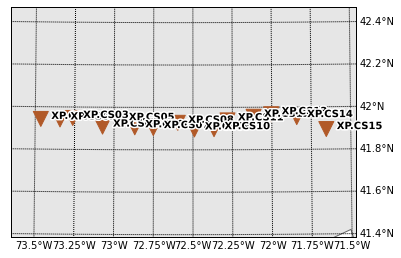

2015-08-01T00:00:00.000000Z 2019-08-01T00:00:00.000000Z
[1, '41.9423', '-73.4647', 0.222, 'CS01']
[2, '41.9408', '-73.3429', 0.187, 'CS02']
[3, '41.9483', '-73.2623', 0.419, 'CS03']
[4, '41.9085', '-73.0730', 0.317, 'CS04']
[5, '41.9396', '-72.9723', 0.256, 'CS05']
[6, '41.9059', '-72.8686', 0.267, 'CS06']
[7, '41.9025', '-72.7512', 0.027, 'CS07']
[8, '41.9275', '-72.5960', 0.003, 'CS08']
[9, '41.8961', '-72.4908', 0.066, 'CS09']
[10, '41.8973', '-72.3665', 0.258, 'CS10']
[11, '41.9386', '-72.2808', 0.208, 'CS11']
[12, '41.9553', '-72.1153', 0.248, 'CS12']
[13, '41.9667', '-72.0038', 0.206, 'CS13']
[14, '41.9522', '-71.8417', 0.16, 'CS14']
[15, '41.8946', '-71.6551', 0.198, 'CS15']


In [4]:
# Get stations, create inventory
model = TauPyModel(model=onedmodel)
client = Client(wf_client)

print("** Getting station data from "+wf_client+" **")

lat_min = 41.68
lat_max = 42.18
lon_min = -73.6
lon_max = -71.4
starttime = UTCDateTime(startdate)
endtime = UTCDateTime(enddate)


print(cha)

inv = client.get_stations(network = net, station = sta, level="response",  channel = cha,
      minlongitude=lon_min, maxlongitude=lon_max, minlatitude=lat_min, maxlatitude=lat_max, 
      starttime=starttime, endtime=endtime)

inv.plot(projection="local",method='basemap')


print(starttime,endtime)
stime = starttime
etime = endtime

station_list = []
lat_list = []
lon_list = []
no = 0
for net in inv:
    for station in net:
#        print(station.latitude)
        if ((station.latitude > lat_min) & (station.latitude < lat_max)):
            if ((station.longitude > lon_min) & (station.longitude < lon_max)):
                no += 1
                station_info = [no,f'{station.latitude:7.4f}',f'{station.longitude:8.4f}',station.elevation/1000.0,station.code]
                station_list.append(station_info)
                lat_list.append(station.latitude)
                lon_list.append(station.longitude)
                print(station_info)                

with open(save_dir + 'all_sta_cord', "w") as output:
    writer = csv.writer(output, delimiter=' ', lineterminator='\n')
    writer.writerows(station_list)



** Getting event data from IRIS **
568 Event(s) in Catalog:
2015-08-05T09:13:22.720000Z | +16.031,  -93.802 | 5.7 MW
2015-08-07T12:18:47.620000Z |  +1.143,  -85.256 | 5.6 MW
...
2019-07-09T11:33:31.667000Z | +47.428, +145.047 | 5.5 Mww
2019-07-31T05:54:55.289000Z | +13.266,  -89.338 | 5.9 Mww
To see all events call 'print(CatalogObject.__str__(print_all=True))'


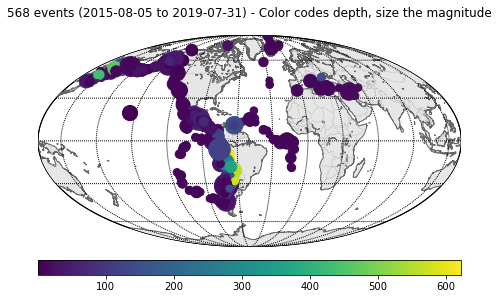

In [5]:
# get events
slat = mean(lat_list)
slon = mean(lon_list)
radm = 6378137.0
pie = np.pi
radian = radm*pie/180.0

evclient = Client(cat_client)
print("** Getting event data from "+cat_client+" **")
cat = evclient.get_events(starttime=stime,
      endtime=etime,minmagnitude=minmag, maxdepth=max_event_depth,latitude=slat,longitude=slon,
      minradius=mindis,maxradius=maxdis,orderby='time-asc')
print(cat)  
cat.plot();



In [14]:
# get waveforms
ev_list = []
count = 0
for event in cat[0:-1]:
    count += 1
    t = UTCDateTime(event.origins[0].time)
    ev_name = str(t.year) + str(t.julday).zfill(3) + str(t.hour).zfill(2) + str(t.minute).zfill(2)
    print("Event No." + str(count) + " - " + ev_name)
    ev_dir = save_dir + ev_name + '/'
    if os.path.exists(ev_dir):
        shutil.rmtree(ev_dir)
    os.makedirs(ev_dir)
    ev_lat = event.origins[0].latitude
    ev_lon = event.origins[0].longitude
    ev_dep = event.origins[0].depth/1000.
    mag = event.magnitudes[0].mag
    
    rawdata = 0
    rows = []
    for net in inv:
        for sta in net:
            slat = sta.latitude
            slon = sta.longitude
            aaa = gps2dist_azimuth(ev_lat,ev_lon,slat,slon)
            epi = aaa[0]/radian
            baz = aaa[2]

            arrP = model.get_travel_times(source_depth_in_km=ev_dep, \
                                       distance_in_degree=epi,phase_list=["P"])
            ptime = arrP[0].time
            if sta.end_date is None:
                sta.end_date = UTCDateTime(2099, 1, 1, 0, 0, 0)
            if ((sta.start_date+24*3600 < (t+ptime-30)) & (sta.end_date-24*3600 > (t+ptime+120))):
                try:
                    st = client.get_waveforms(network=net.code, station=sta.code,
                                              location="*", channel="BH?",
                                              starttime=t+ptime-30, endtime=t+ptime+120,attach_response=True)
                except:
                    print(sta.code + ' somehow does not have data for event ' + ev_name)
                    continue
                try:
                    st.rotate(method="->ZNE", inventory=inv)
                    st.rotate(method="NE->RT",back_azimuth = baz)
                except:
                    print('Channels of ' + sta.code + ' cannot be rotated, probably due to unaligned time series.')
                    continue
                rawdata += 1
                st.detrend('demean')
                st.detrend('linear')
                st.filter(type="bandpass",freqmin=0.03,freqmax=4.9,zerophase=True)
                st.taper(0.05,type='Hamming',max_length=7.5)
#                st.remove_response(inventory=inv, pre_filt=[0.01 0.03 4.9 6.9], output="DISP", water_level=100) 
                try:
                    st[2].write(ev_dir+'dum'+st[2].stats.channel[2]+'.sac',format='SAC')
                    st[1].write(ev_dir+'dum'+st[1].stats.channel[2]+'.sac',format='SAC')
                    st[0].write(ev_dir+'dum'+st[0].stats.channel[2]+'.sac',format='SAC')
                except:
                    print(sta.code + ' does not have 3 required channels for ' + ev_name)
                    continue
                if (st[2].stats.npts < 6000) | (st[1].stats.npts < 6000) | (st[0].stats.npts < 6000):
                    print(sta.code + ' does not have complete record for ' + ev_name)
                    continue
                    
                stZ = read(ev_dir+'dumZ.sac')
                stR = read(ev_dir+'dumR.sac')
                stT = read(ev_dir+'dumT.sac')
                os.remove(ev_dir+'dumZ.sac')
                os.remove(ev_dir+'dumR.sac')
                os.remove(ev_dir+'dumT.sac')
                trZ = stZ[0]
                trR = stR[0]
                trT = stT[0]
                f1 = SNR(trZ,trR,5,4,0.03,0.3)
                f2 = SNR(trZ,trR,5,4,0.03,0.6)
                f3 = SNR(trZ,trR,5,4,0.03,1.0)
                trZ.stats.sac.user1=f1
                trZ.stats.sac.user2=f2
                trZ.stats.sac.user3=f3
                trR.stats.sac.user1=f1
                trR.stats.sac.user2=f2
                trR.stats.sac.user3=f3
                trT.stats.sac.user1=f1
                trT.stats.sac.user2=f2
                trT.stats.sac.user3=f3
                trZ.stats.sac.user0=arrP[0].ray_param/6371
                trR.stats.sac.user0=arrP[0].ray_param/6371
                trT.stats.sac.user0=arrP[0].ray_param/6371

                if f1+f2+f3>0:
                    sta_dir = ev_dir + sta.code +'/'
                    os.makedirs(sta_dir)
                    trZ.write(sta_dir + 'STACK_Z',format='SAC')
                    trR.write(sta_dir + 'STACK_R',format='SAC')
                    trT.write(sta_dir + 'STACK_T',format='SAC')
                    row = [sta.code,str(t.year),str(t.month).zfill(2),str(t.day).zfill(2),
                           str(t.hour).zfill(2),str(t.minute).zfill(2),
                           str(t.second).zfill(2)+'.'+str(int(t.microsecond/100)).zfill(3),
                          f'{ev_lat:7.4f}',f'{ev_lon:8.4f}',ev_dep,mag,f'{epi:7.4f}',f'{baz:7.4f}']
                    rows.append(row)

    with open(ev_dir + 'evinfo', "w") as output:
        writer = csv.writer(output, delimiter=' ', lineterminator='\n')
        writer.writerows(rows)
    
    qcdata = len(rows)
    print('Number of stations: ' + str(rawdata) + ' Passed QC: ' + str(qcdata))
    ev_sta = [ev_name,str(rawdata),str(qcdata)]
    ev_list.append(ev_sta)
    
    if qcdata < 8:
        shutil.rmtree(ev_dir)

with open(save_dir + 'ev_list', "w") as output:
    writer = csv.writer(output, delimiter=' ', lineterminator='\n')
    writer.writerows(ev_list)
    


Event No.1 - 20152170913
Number of stations: 1 Passed QC: 0
Event No.2 - 20152191218
CS02 somehow does not have data for event 20152191218
Number of stations: 1 Passed QC: 0
Event No.3 - 20152191348
CS02 somehow does not have data for event 20152191348
Number of stations: 1 Passed QC: 0
Event No.4 - 20152240014
CS02 somehow does not have data for event 20152240014
CS13 somehow does not have data for event 20152240014
Number of stations: 1 Passed QC: 0
Event No.5 - 20152261803
CS02 somehow does not have data for event 20152261803
CS13 somehow does not have data for event 20152261803
Number of stations: 1 Passed QC: 0
Event No.6 - 20152272016
CS02 somehow does not have data for event 20152272016
CS13 somehow does not have data for event 20152272016
Number of stations: 1 Passed QC: 0
Event No.7 - 20152350448
CS13 somehow does not have data for event 20152350448
Number of stations: 2 Passed QC: 1
Event No.8 - 20152352310
CS13 somehow does not have data for event 20152352310
Number of stati